# BLU04 - Learning Notebook - Part 2 of 3 - Multi-indexing

## Basic multi-index concept

Up to here, we've been working under the assumption that our data is two dimensional. That's why it fits so well in a tabular form, and would do quite well in a simple spreadsheet.

Let's change that! 

In [42]:
import pandas as pd 
from datetime import datetime
%matplotlib inline 
from matplotlib import pyplot as plt 
plt.rcParams['figure.figsize'] = [16, 4]

Let's take a toy dataset, with some supermarket foods:

In [43]:
food = pd.read_csv('data/food.csv')
food

,Store,Product,Price,Quality
0,Incontinente,Apples,3.0,2.0
1,Incontinente,Bananas,2.0,4.0
2,Incontinente,Rice,1.0,3.0
3,Incontinente,Olives,4.0,2.0
4,Dingo Poce,Apples,2.0,2.0
5,Dingo Poce,Bananas,3.0,3.0
6,Dingo Poce,Rice,1.0,4.0
7,Dingo Poce,Dog food,7.0,1.0
8,Dumbo,Rice,5.0,4.0
9,Dumbo,Dog food,1.0,2.0


Let's think about indexes. So far, we had, for each row, some unique ID. But in the above case, we have several supermarkets and several products. 

So if, for instance, we had to merge this with another dataset, we would want to use "supermarket/food" pairs, so that we have **unique indexes**. 

In this case, our prices and quality depend on the **Store** AND on the **Product**. So our index needs to contain both. 

Having unique indexes is super useful. To the point that you might be tempted to do this: 

In [44]:
possible_index = food['Store'] + '_' + food['Product']

In [45]:
food.set_index(possible_index).head()

,Store,Product,Price,Quality
Incontinente_Apples,Incontinente,Apples,3.0,2.0
Incontinente_Bananas,Incontinente,Bananas,2.0,4.0
Incontinente_Rice,Incontinente,Rice,1.0,3.0
Incontinente_Olives,Incontinente,Olives,4.0,2.0
Dingo Poce_Apples,Dingo Poce,Apples,2.0,2.0


I mean... it's not great, but we can now select it, or merge it with other data. 

But Pandas can help us do this much, much better: 

In [46]:
food = food.set_index(['Store', 'Product'])

food

Price  Quality
Store        Product                 
Incontinente Apples      3.0      2.0
             Bananas     2.0      4.0
             Rice        1.0      3.0
             Olives      4.0      2.0
Dingo Poce   Apples      2.0      2.0
             Bananas     3.0      3.0
             Rice        1.0      4.0
             Dog food    7.0      1.0
Dumbo        Rice        5.0      4.0
             Dog food    1.0      2.0
             Apples      2.0      3.0

Multi-indexes are crazy useful, especially when the datasets get bigger. They allow us to go into higher dimentions than two dimentions, and keep the intuitive "tabular" structure. 



Let's learn how to select from this! 

## Selecting in multi-indexes

### loc

Remember loc? Loc is awesome :) 

Remember, loc allows you to select by doing `data.loc[index, columns]`

Now that we have multiple index levels, we will have to use it a bit more explicitly. 

In [47]:
food

Price  Quality
Store        Product                 
Incontinente Apples      3.0      2.0
             Bananas     2.0      4.0
             Rice        1.0      3.0
             Olives      4.0      2.0
Dingo Poce   Apples      2.0      2.0
             Bananas     3.0      3.0
             Rice        1.0      4.0
             Dog food    7.0      1.0
Dumbo        Rice        5.0      4.0
             Dog food    1.0      2.0
             Apples      2.0      3.0

Let's say we wanted to get the price of Apples, at Dingo Poce. If this were just a 1 level index, we would just say `data.loc[row, column]`. 

However, we have two levels of index. Maybe we must pass the index part as a tuple?

In other words, can we get our answer with `data.loc[(first_index_level, _second_index_level), column]`?

In [48]:
food.loc[('Dingo Poce', 'Apples'), 'Price']

# note: this is not the best way to do this, if you are using this for reference, read down to idx

2.0

We can! _(spoiler alert: we're going to get in trouble with this)_

 Let's get all of the prices at Dingo Poce

In [49]:
# note that the first part is a tuple of (Dingo Poce, <nothing>)
food.loc[('Dingo Poce',), 'Price']

# this cell should throw a performance warning. It only does it the first time you run it though.

/home/sonia/.virtualenvs/blu04/lib/python3.6/site-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


Product
Apples      2.0
Bananas     3.0
Rice        1.0
Dog food    7.0
Name: Price, dtype: float64

What's this? `PerformanceWarning: indexing past lexsort depth may impact performance.`? That looks serious!

If you want to get into the details, check out this chapter in [the documentation](http://pandas.pydata.org/pandas-docs/stable/advanced.html#the-need-for-sortedness-with-multiindex), but if you just want to know what to do remember this: 

> **_Always, for the sake of your own mental sanity, sort your indexes in a multi-index._**

This will not only increase performance, but also avoid some bugs from hell. So, let's sort our index!

In [50]:
food = food.sort_index()

Now, maybe we want the apples, everywhere? 

In [51]:
# will raise SyntaxError
# food.loc[(,'Apples'), 'Price']

Ok, right. That makes no sense. Maybe if we use `:`? 

In [52]:
# will raise SyntaxError
# food.loc[(:,'Apples'), 'Price']

Hmm... looks like we got as far as we could with our hackiness. Formally, what we are asking for is called [index slices](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.IndexSlice.html). I'll teach you some [syntactic sugar](https://en.wikipedia.org/wiki/Syntactic_sugar) for this in a second, but let's go old school first, with actual slices. 

Remember, our question is **_"What is the price of apples, at all stores?"_**

In [53]:
food.loc[(slice(None), slice('Apples', 'Apples')), 'Price']

Store         Product
Dingo Poce    Apples     2.0
Dumbo         Apples     2.0
Incontinente  Apples     3.0
Name: Price, dtype: float64

[Python slices](https://www.programiz.com/python-programming/methods/built-in/slice) have starts and ends, so you can use them to select, as long as things are sorted: 

In [54]:
food.loc[(slice(None), slice('Apples', 'Bananas')), 'Price']

Store         Product
Dingo Poce    Apples     2.0
              Bananas    3.0
Dumbo         Apples     2.0
Incontinente  Apples     3.0
              Bananas    2.0
Name: Price, dtype: float64

Well, that worked! We had to write the word "slice" a couple of times, but it got our answer. Also, what the hell is up with that `('Apples', 'Apples)` thing? 

Well, as they are regular [Python slices](https://www.programiz.com/python-programming/methods/built-in/slice), we need to use the syntax `slice(start, stop, step)`. Which isn't very Pandas-like.

So now, as promised... 

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSDH-Vflk72pHd443Eatl9mvEfpSt_Ca32UfjDovk-QhwDbo__tew)

**Time for some syntactic sugar!** Technically, the following is just convention, but it will make your life easier, and you will see lots of code that uses this, so it's a good idea to get familiar with it. 

We will use `pd.IndexSlice`, which in pandas is generally called `idx` for a convenience. It replaces the need to say "slice" all over the place. 

Index slices do exactly what the name suggests: they take slices from the index. Other than that, we use the same approach as with the "normal" `loc[slice(), slice(), something]`. 

So in this case, we have two index levels, so we will have: 
    `data.loc[idx[index_level_0, index_level_1], columns]`

In [55]:
idx = pd.IndexSlice  # <---- convention, get ready to copy paste this a lot 

In [56]:
food.loc[idx[: , 'Apples'], 'Price']

Store         Product
Dingo Poce    Apples     2.0
Dumbo         Apples     2.0
Incontinente  Apples     3.0
Name: Price, dtype: float64

Quick summary before we move on. The following three are equivalent: 

In [57]:
# get me, at any supermarket, the apples, and I'm only interested in the price 

# The way that breaks Python, and hearts 
# food.loc[(:,'Apples'), 'Price']  <--- syntax error :( 

# The slicy way 
food.loc[(slice(None), slice('Apples', 'Apples')), 'Price'];

# The "pandas insider" way 
food.loc[idx[: , 'Apples'], 'Price'];

Great! Now that I've [fully converted you](https://i.imgflip.com/29imng.jpg) to Pandas convention, I will use [advanced indexing with idx](https://pandas.pydata.org/pandas-docs/stable/advanced.html#using-slicers) through the rest of the BLUs. 

Let's answer another question: _What are all the prices at Dingo Poce?_

In [58]:
# from food, 
# A) get the slice of the index 
# B) where the index_level_0 is 'Dingo Poce', 
# C) and everything on the second level (:)
# D) also, give me all the columns (:)

# food.loc[A[B, C], D]
food.loc[idx['Dingo Poce', :], :]

Price  Quality
Store      Product                 
Dingo Poce Apples      2.0      2.0
           Bananas     3.0      3.0
           Dog food    7.0      1.0
           Rice        1.0      4.0

Now you may be asking yourself the following: 

> _"sure, but I've been calling loc with just one argument, because I'm cool. Maybe I can do that here?"_

In [59]:
# Oy! Pandas! Get me Dingo Poce, and you figure out what I mean! 
food.loc['Dingo Poce']

,Price,Quality
Product,,
Apples,2.0,2.0
Bananas,3.0,3.0
Dog food,7.0,1.0
Rice,1.0,4.0


This will work, as long as you are selecting from the first level of the index.  
Pandas kind of has to say _"hmmm... I'm going to go ahead and assume you **meant** `food.loc['Dingo Poce', :, :]`"_

The problem with not being explicit is that now that we're in multi-index land, things can go wrong. What if I wanted to select from the second level (let's say we want "all the apples")?

In [60]:
# this is going to blow up, so let's catch the error 
try:
    # Oy! Pandas! Get me Apples, and you figure out what I mean!
    food.loc['Apples']
# catch the error 
except KeyError as key_err:
    # print it 
    print('We got this error: %s' % key_err)

We got this error: 'Apples'


Kind of makes sense, right?  
It doesn't know in which level of axis we mean, and we because we didn't say anything, it just looked for a Store called _Apples_ (the _"Apples store"_ ), and didn't find any. 

So let's establish a rule here: 
> **"Always be explicit, even when implicit has a good chance of working.**"

The reason is that when things fail, and you get used to using the "slightly incorrect way" and expecting Pandas to forgive you, you will suffer. Big time. 

So, let's be explicit: 

In [61]:
# from food, 
# A) get the slice of the index 
# B) where we want everything from the first level of the index 
# C) and only the apples from the second level of the index 
# D) again, all of the columns 

# food.loc[A[B, C], D]
food.loc[idx[:, 'Apples'], :]

# idx is love. idx is life. 

,,Price,Quality
Store,Product,,
Dingo Poce,Apples,2.0,2.0
Dumbo,Apples,2.0,3.0
Incontinente,Apples,3.0,2.0


That works! Let's do a few more, for practice: 

##### _"The apples at Dingo Poce"_

In [62]:
food.loc[idx['Dingo Poce', 'Apples'], :]

Price      2.0
Quality    2.0
Name: (Dingo Poce, Apples), dtype: float64

##### _"The price of Bananas, at any store"_

In [63]:
food.loc[idx[:, 'Bananas'], 'Price']

Store         Product
Dingo Poce    Bananas    3.0
Incontinente  Bananas    2.0
Name: Price, dtype: float64

##### _"The quality of Olives, at any Incontinente"_

In [64]:
food.loc[idx['Incontinente', 'Olives'], 'Quality']

2.0

##### _"The quality of Rice and Bananas, at any Incontinente"_

In [65]:
# notice that we can pass a list to the second half of the index slice
food.loc[idx['Incontinente', ['Bananas', 'Rice']], 'Quality']

Store         Product
Incontinente  Bananas    4.0
              Rice       3.0
Name: Quality, dtype: float64

---- 

### Slicing in multi-indexes 

Sometimes instead of listing the values we want, we might want to take slices. 

Here it will be by alphabetical order (to keep the example simple), but we will see how powerful this is later when we bring in the timeseries. 

From a syntax point of view, slicing means passing `start: end` to our `.loc`, instead of explicitly naming every entry. 

Let's get the quality of the products "from bananas to rice" in Incontinente (from "b" to "r"). This would be problematic if the dataset were not sorted. 

In [66]:
# Notice the nomenclature "start: end" 
food.loc[idx['Incontinente', 'Bananas': 'Rice'], 'Quality']

Store         Product
Incontinente  Bananas    4.0
              Olives     2.0
              Rice       3.0
Name: Quality, dtype: float64

**Optional:** You can also slice on partial string values _(in a more Pythonesque, and less Pandasesque way)_ , but beware of the right-inclusive problem. 

In [67]:
# Notice the nomenclature "start: end" 
food.loc[idx['Incontinente', 'B': 'S'], 'Quality']

Store         Product
Incontinente  Bananas    4.0
              Olives     2.0
              Rice       3.0
Name: Quality, dtype: float64

### Groupby (group-apply-combine) in multi-indexes

Let's say we want to know the lowest prices at which we can get each product.  

In the case of this tiny dataset, we can just look directly at the data, or select each product at the time and then take the `.min`, but we will use this very simply question to illustrate a powerful concept. 

In [68]:
food

Price  Quality
Store        Product                 
Dingo Poce   Apples      2.0      2.0
             Bananas     3.0      3.0
             Dog food    7.0      1.0
             Rice        1.0      4.0
Dumbo        Apples      2.0      3.0
             Dog food    1.0      2.0
             Rice        5.0      4.0
Incontinente Apples      3.0      2.0
             Bananas     2.0      4.0
             Olives      4.0      2.0
             Rice        1.0      3.0

In [28]:
food.groupby(level='Product').Price.min()

Product
Apples      2.0
Bananas     2.0
Dog food    1.0
Olives      4.0
Rice        1.0
Name: Price, dtype: float64

Eh... that's cool, but a better questions is _"Where should I buy each product, and how much will it cost there?"_

In [69]:
apples_data = food.loc[idx[:, 'Apples'], :]
apples_data.loc[apples_data.Price == apples_data.Price.min()]

,,Price,Quality
Store,Product,,
Dingo Poce,Apples,2.0,2.0
Dumbo,Apples,2.0,3.0


Where is each product cheaper?

In [70]:
food.groupby(level='Product').Price.idxmin()

Product
Apples         (Dingo Poce, Apples)
Bananas     (Incontinente, Bananas)
Dog food          (Dumbo, Dog food)
Olives       (Incontinente, Olives)
Rice             (Dingo Poce, Rice)
Name: Price, dtype: object

**Important!** [idxmin](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwjO9Z_n0OTaAhWHiywKHXLoDp8QFggpMAA&url=https%3A%2F%2Fpandas.pydata.org%2Fpandas-docs%2Fstable%2Fgenerated%2Fpandas.DataFrame.idxmin.html&usg=AOvVaw05Ahs2GI2lkoZacYuqRpEx), while quick and easy to use, finds only "the first index where the min is found". 

If you want to find all of the stores where the price is min, you need to use the slightly more advanced methods in the following section. 90% of the time though, idxmin is enough for practical purposes.

So we found out where the food is cheapest. But now I'm worried about the quality... 

We already know where things are cheaper, let's call it `where_stuff_is_cheapest`

In [71]:
where_stuff_is_cheapest = food.groupby(level='Product').Price.idxmin()

In [72]:
where_stuff_is_cheapest.head(2)

Product
Apples        (Dingo Poce, Apples)
Bananas    (Incontinente, Bananas)
Name: Price, dtype: object

Now we can use this to select. Notice we don't need `idx`, because our index is already a tuple. 

In [73]:
# food, where the indexes of the minimum prices are, with the columns Quality and Price 
food.loc[where_stuff_is_cheapest, ['Quality', 'Price']]

,,Quality,Price
Store,Product,,
Dingo Poce,Apples,2.0,2.0
Incontinente,Bananas,4.0,2.0
Dumbo,Dog food,2.0,1.0
Incontinente,Olives,2.0,4.0
Dingo Poce,Rice,4.0,1.0


So... the minimum price, but only where the quality is higher than 3? 

In [74]:
# Sigh.... ok, so food where the quality is at least 3...
at_least_3_quality_food = food.loc[food.Quality >=3]

# get the indexes where the lowest price occurs 
index_where_lowest_price = at_least_3_quality_food.groupby(level='Product').Price.idxmin()

# now from the food where the quality is at least 3, 
# get the indexes where the price is minimum, 
# and show both quality and price
at_least_3_quality_food.loc[index_where_lowest_price, ['Quality', 'Price']]

,,Quality,Price
Store,Product,,
Dumbo,Apples,3.0,2.0
Incontinente,Bananas,4.0,2.0
Dingo Poce,Rice,4.0,1.0


It's so beautiful! 

## Bring in the timeseries! 

Ok, so that was a basic idea of multi-indexing. But that's not what you are here for, you are here for timeseries!

Let's get back to business! 

Let's take all of the stocks from an exchange between 2007 and 2011

In [75]:
data = pd.read_csv('data/stocks.csv')

In [76]:
data.head()

,Date,Stock,Open,High,Low,Close,Volume
0,2007-01-03,nhc,46.2710,46.4810,45.5640,46.2710,26244
1,2007-01-03,vhi,3.0205,3.0205,2.8661,2.9215,94069
2,2007-01-03,bpt,37.5560,37.5560,37.0750,37.1820,489258
3,2007-01-03,cet,12.4790,12.4960,12.4060,12.4250,36413
4,2007-01-03,lndc,10.7000,11.3700,10.5000,11.3400,245349


How much data do we have? 

In [77]:
data.shape

(475041, 7)

Cool, and we already know how to fix datetimes: 

In [78]:
data['Date'] = pd.to_datetime(data['Date'])

Now, consider this sentence carefully: 

> _**For each stock, for each date**, we have an Open, High, Low, Close, and Volume_

Which means that we have a multi-index, with both date, and stock! 

In [79]:
data = data.set_index(['Date', 'Stock'])
data.head()

Open     High      Low    Close  Volume
Date       Stock                                            
2007-01-03 nhc    46.2710  46.4810  45.5640  46.2710   26244
           vhi     3.0205   3.0205   2.8661   2.9215   94069
           bpt    37.5560  37.5560  37.0750  37.1820  489258
           cet    12.4790  12.4960  12.4060  12.4250   36413
           lndc   10.7000  11.3700  10.5000  11.3400  245349

As mentioned before, we must sort our index:

In [80]:
data = data.sort_index()
data.head()

Open      High       Low     Close   Volume
Date       Stock                                                 
2007-01-03 aap      35.139    35.621    34.527    35.011   776642
           abb      13.422    13.429    13.105    13.192  4030670
           achn     16.430    17.280    16.060    17.280    55226
           achv   1227.600  1231.560  1158.300  1191.960      785
           adm      27.457    27.864    27.065    27.269  8670704

##### Select Microsoft (msft):

In [82]:
idx = pd.IndexSlice
data.loc[idx[:,'msft'],:]

,,Open,High,Low,Close,Volume
Date,Stock,,,,,
2007-01-03,msft,25.073,25.367,24.655,25.041,91732862
2007-01-04,msft,24.898,25.132,24.688,24.998,54581739
2007-01-05,msft,24.832,24.948,24.697,24.856,53189559
2007-01-08,msft,24.864,25.242,24.764,25.099,59801289
2007-01-09,msft,25.141,25.308,24.930,25.123,53215396
...,...,...,...,...,...,...
2010-12-27,msft,23.572,23.648,23.379,23.539,25804221
2010-12-28,msft,23.455,23.624,23.446,23.490,27473907
2010-12-29,msft,23.429,23.582,23.381,23.457,23237632


In [83]:
data.loc[idx[:, 'msft'], :].head()

,,Open,High,Low,Close,Volume
Date,Stock,,,,,
2007-01-03,msft,25.073,25.367,24.655,25.041,91732862
2007-01-04,msft,24.898,25.132,24.688,24.998,54581739
2007-01-05,msft,24.832,24.948,24.697,24.856,53189559
2007-01-08,msft,24.864,25.242,24.764,25.099,59801289
2007-01-09,msft,25.141,25.308,24.930,25.123,53215396


##### Select all stocks from May  20th, 2009 

In [ ]:
data.loc[idx['May 20th, 2009', :], :].head(10)

##### Select the Close price of Microsoft, IBM and Ebay, between June 10th and June 14th, 2008?

In [85]:
data.loc[idx['June 10th,2008':'June 14th,2008',['msft','ibm','ebay']],'Close']

Date        Stock
2008-06-10  ebay      12.197
            ibm      105.170
            msft      23.389
2008-06-11  ebay      11.667
            ibm      102.920
            msft      22.744
2008-06-12  ebay      11.818
            ibm      103.420
            msft      23.682
2008-06-13  ebay      11.944
            ibm      105.350
            msft      24.377
Name: Close, dtype: float64

In [86]:
close_prices_tech_3 = data.loc[idx['June 10th, 2008':'June 14th, 2008', ['msft', 'ibm' ,'ebay']], 'Close']

close_prices_tech_3

Date        Stock
2008-06-10  ebay      12.197
            ibm      105.170
            msft      23.389
2008-06-11  ebay      11.667
            ibm      102.920
            msft      22.744
2008-06-12  ebay      11.818
            ibm      103.420
            msft      23.682
2008-06-13  ebay      11.944
            ibm      105.350
            msft      24.377
Name: Close, dtype: float64

##### Once you have the data at this stage, you can [unstack](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.unstack.html). 

Unstack essentially takes the first level of the index and keeps it as the index, and takes the second level and makes it the columns. 

In [87]:
close_prices_tech_3.unstack()

Stock,ebay,ibm,msft
Date,,,
2008-06-10,12.197,105.17,23.389
2008-06-11,11.667,102.92,22.744
2008-06-12,11.818,103.42,23.682
2008-06-13,11.944,105.35,24.377


Remember that if you're going to be indexing a certain interval several times it's probably better to create a python slice:

In [ ]:
interval = slice('June 10th, 2008','June 14th, 2008')
data.loc[idx[interval, ['msft', 'ibm' ,'ebay']], 'Close']

#### Working with the index directly 

For fun, we can also ask questions such as: 
> _"What was the average price of stocks on Mondays?"_ 

For this we will use a boolean mask, and a new method, [get_level_values](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwjTisXGrOjaAhXHzRQKHSfJCq8QFggpMAA&url=https%3A%2F%2Fpandas.pydata.org%2Fpandas-docs%2Fstable%2Fgenerated%2Fpandas.Index.get_level_values.html&usg=AOvVaw3XDga7SdrZkID3lvOtiaDz)

In [88]:
data.head()

Open      High       Low     Close   Volume
Date       Stock                                                 
2007-01-03 aap      35.139    35.621    34.527    35.011   776642
           abb      13.422    13.429    13.105    13.192  4030670
           achn     16.430    17.280    16.060    17.280    55226
           achv   1227.600  1231.560  1158.300  1191.960      785
           adm      27.457    27.864    27.065    27.269  8670704

In [91]:
data.loc[data.index.get_level_values(0).day_name()=='Monday'].Close.mean()

49.9034682798239

In [92]:
# Make a boolean mask, as to whether the day is Monday. 
# Notice two things: 
# 1. the use of get_level_values(0), to get the index at the dates level
# 2. the use of .weekday_name directly on the index (no need for .dt)
is_monday = data.index.get_level_values(0).day_name() == 'Monday'

# Now use that boolean mask to get the data for Mondays, then get the mean close price
mondays_data = data.loc[is_monday].Close.mean()

print('Mean Monday price: %0.2f' % mondays_data)

Mean Monday price: 49.90


## Plotting 
#### (and why `xs` is sometimes a useful alternative) 

##### Plot the close prices for Microsoft:

Using the previous approach, let's try to make a plot:

/home/sonia/.virtualenvs/blu04/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Date,Stock'>

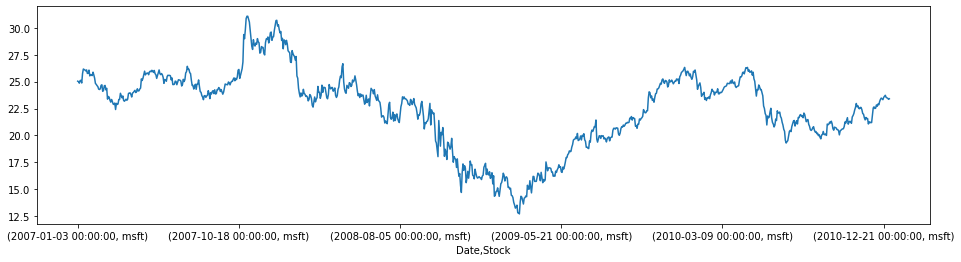

In [93]:
data.loc[idx[:, 'msft'], 'Close'].plot()

Well that's annoying, it didn't make a pretty X axis with the dates, because the index is date, stock. 

The reason is slightly annoying: even though we only have msft in the index, it still exists: 

In [94]:
data.loc[idx[:, 'msft'], 'Close'].head(5)

Date        Stock
2007-01-03  msft     25.041
2007-01-04  msft     24.998
2007-01-05  msft     24.856
2007-01-08  msft     25.099
2007-01-09  msft     25.123
Name: Close, dtype: float64

One hacky way to do this would be to say "ok fine, just make the index the dates, and then plot it":

In [95]:
msft_close = data.loc[idx[:, 'msft'], 'Close']

msft_close.head(2)

Date        Stock
2007-01-03  msft     25.041
2007-01-04  msft     24.998
Name: Close, dtype: float64

Now we can actually change the index by hand, and say we just want that level: 

In [ ]:
msft_close.index = msft_close.index.get_level_values('Date')
msft_close.head(2)

And now finally do our pretty plot: 

In [ ]:
msft_close.plot()

However there is another way, which is to use cross sections, with [`xs`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.xs.html): 

/home/sonia/.virtualenvs/blu04/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Date,Stock'>

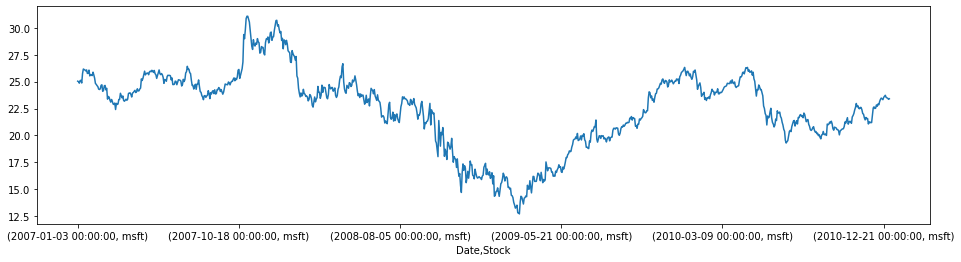

In [97]:
data.loc[idx[:, 'msft'], 'Close'].plot()

In [96]:
data.xs('msft',                       # <---- msft
        level='Stock',                # <---- which is at index level "Stock"
        drop_level=True).head()       # <---- Get rid of the level, so that the index shows the dates

,Open,High,Low,Close,Volume
Date,,,,,
2007-01-03,25.073,25.367,24.655,25.041,91732862
2007-01-04,24.898,25.132,24.688,24.998,54581739
2007-01-05,24.832,24.948,24.697,24.856,53189559
2007-01-08,24.864,25.242,24.764,25.099,59801289
2007-01-09,25.141,25.308,24.930,25.123,53215396


And now, plot it! 

<AxesSubplot:xlabel='Date'>

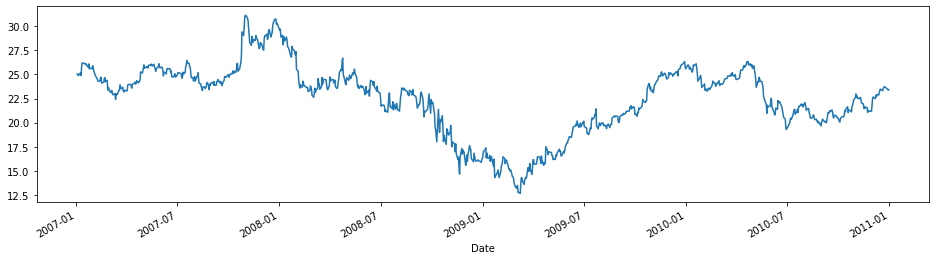

In [98]:
data.xs('msft', level='Stock', drop_level=True).Close.plot()

As with so much in Pandas, there is more than one way to do things, and you will probably run into `xs(...)` sometimes, `loc[idx[...]]` other times. 

A suggestions is to get used to using `loc`, as it is more general and more powerful, but to know that when you get stuck, you can always pick up an alternative (you'll see a lot of `xs` in StackOverflow answers)

## Groupby, and operations 

After this detour, let's get back to our main dataset: 

In [99]:
data.head(3)

Open    High     Low   Close   Volume
Date       Stock                                         
2007-01-03 aap    35.139  35.621  34.527  35.011   776642
           abb    13.422  13.429  13.105  13.192  4030670
           achn   16.430  17.280  16.060  17.280    55226

Let's think about the following question. We want to calculate the percentage difference, from day to day. 

Can we just sort the data by stock, and then do `.pct_change`?  (spoiler alert: the answer is going to be "No")

In [100]:
data.sort_index(level=['Stock', 'Date']).Close.pct_change().head()

Date        Stock
2007-01-03  aap           NaN
2007-01-04  aap      0.006455
2007-01-05  aap     -0.022136
2007-01-08  aap      0.003454
2007-01-09  aap      0.008561
Name: Close, dtype: float64

So seems sensible enough... 

However, let's inspect a row where we transition from one stock to the other:

In [105]:
# how long is stock 1?
end_of_first_stock = len(data.loc[idx[:, 'aap'], :])
# show the transition point:
data.sort_index(level=['Stock', 'Date']).Close.pct_change().iloc[end_of_first_stock - 3: end_of_first_stock + 3]

Date        Stock
2010-12-29  aap      0.003022
2010-12-30  aap      0.004068
2010-12-31  aap     -0.008545
2007-01-03  abb     -0.797327
2007-01-04  abb     -0.031762
2007-01-05  abb     -0.018790
Name: Close, dtype: float64

So what did we do on that transition? We subtracted one stock, on one day, to another stock on a different year! 

**What's the right way to do this?** _(well, the chapter IS called Groupby...)_

In [106]:
# group by the stock, and then take the Close, and calculate percentage change 
data.groupby(level='Stock').Close.pct_change().head()

Date        Stock
2007-01-03  aap     NaN
            abb     NaN
            achn    NaN
            achv    NaN
            adm     NaN
Name: Close, dtype: float64

Wait what? Oh, right. On the first day, there isn't a previous day to calculate change. Let's take a look at another day: 

In [107]:
# exceptionally I'm using the "lazy" way to do loc here, for the sake of simplicity:

data.groupby(level='Stock').Close.pct_change().loc['May 5th 2008'].head()

Date        Stock
2008-05-05  aap     -0.018962
            abb      0.004548
            achn     0.045946
            achv     0.020468
            adm      0.003425
Name: Close, dtype: float64

Let's manually check this. What was the price for `abb` on `2008-05-05`?

In [108]:
data.loc[idx['May 5th 2008', 'abb'], 'Close']

Date        Stock
2008-05-05  abb      22.97
Name: Close, dtype: float64

And on the previous day? 

In [109]:
data.loc[idx['May 4th 2008', 'abb'], 'Close']

Series([], Name: Close, dtype: float64)

Uuuhh... no data on that day! Which makes it particularly cool that Pandas figures out on its own to look on the previous day where there is some data. 

In [110]:
data.loc[idx['May 2th 2008': 'May 5th 2008', 'abb'], 'Close']

Date        Stock
2008-05-02  abb      22.866
2008-05-05  abb      22.970
Name: Close, dtype: float64

What is the percentage change between the two days? 

In [111]:
print('Percentage change between the consecutive days: %0.6f:' % ((22.970 - 22.866) / 22.866))

Percentage change between the consecutive days: 0.004548:


Which is exactly what we got! 

# A few other notes on multi-indexing 

Multi-indexing, and particularly multi-indexing with time series is a giant world. There are many redundant ways to do things, and it is not our intention to make you learn every single method out there.   

There are way too many redundant ways to do things, and most of the time you can simply hack around obstacles without adding more tools. 

The objective here is to give you enough tools to solve 80% of the problems, and know where to look on the other 20%   

We talked about mutli-indexing at the row level, but we can also do multi-indexing at column level!  Not done here to avoid unnecessary complexity. There be dragons. Dragons with machine guns. 

There are a LOT of wrong and obsolete answers out there. Be a bit cynical when reading stackoverflow answers, or old blog posts. Many things are already deprecated, and lots of answers that you will find out there don't actually work.   

You now know the basics of Multi-indexing in time series. That makes you part of a pretty small group of people who have studied this intimidating field. Consider yourself initiated, and sworn to a secret illuminati society.   

References: 

- [Somebits](https://www.somebits.com/~nelson/pandas-multiindex-slice-demo.html)
- [Pandas multi-index documentation](http://pandas.pydata.org/pandas-docs/stable/advanced.html#multiindex-advanced-indexing)

-----

### **Summary of the methods we have learnt in this unit:**
* `loc` - loc allows you to select by doing `dataframe.loc[index, columns]`
* We can use idx = `pd.IndexSlice` so that we don't have to use `slice()` all over the place. This will take slices from the index 
* Selecting from multi-index: `dataframe.loc[idx[index_level_0, index_level_1], columns]`
* Groupby different levels: `dataframe.groupby(level=<level_you_want>).mean()` -> Remember you need an aggregation function after groupby. 
* Finding the first occurrence of the min or the max: `idxmin()` or `idxmax()`
* Aggregate by more than one method at a time: `agg()`
* Put one of the multi-index level into columns: `unstack()`
* Using cross sections: `xs()`

### **A few examples:** 

    * An example we have seen: `food.loc[idx['Dingo Poce', :], :]`
    * Slicing multi-index: `food.loc[idx['Incontinente', 'Bananas': 'Rice'], 'Quality']`
    * groupby Product and get the minimum Price: `food.groupby(level='Product').Price.min()`
    * Aggregate by more than one method: `food.groupby(level='Product').agg({'Price':['idxmin', 'min']})`
    * Example of unstack: `data.loc[idx['June 10th, 2008':'June 14th, 2008', ['msft', 'ibm' ,'ebay']],'Close'].unstack()`
    * Example of cross sections: `data.xs('msft', level='Stock', drop_level=True)`

-----

### Optional section (groupby with lambda functions)

In [112]:
food.groupby(level='Product').Price.agg(lambda x: list(x.loc[x == x.min()].index))

Product
Apples         [(Dingo Poce, Apples), (Dumbo, Apples)]
Bananas                      [(Incontinente, Bananas)]
Dog food                           [(Dumbo, Dog food)]
Olives                        [(Incontinente, Olives)]
Rice        [(Dingo Poce, Rice), (Incontinente, Rice)]
Name: Price, dtype: object

We might also want to aggregate by more than one method at the time: 

In [ ]:
food.groupby(level='Product').agg({'Price':['idxmin', 'min']})

Sometimes the level of complexity leads to [this conclusion](https://youtu.be/syhlPzqEpkE?t=28s)

###  End of optional section